<a href="https://colab.research.google.com/github/Henchen99/BEng-Project/blob/main/Household_load_profile/Household_load_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Household load forecast

Aim of this notebook is to find ideal periods of charging times based on household data and TOU pricing. We assume the user is at home when the household load increases, and also at night so we will aim to charge in this time. Therefore we need to find wat time everyday the user it typically at home and then match these times with the cheapest cost of energy. 

In [ ]:
pip install pmdarima

      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
from matplotlib import pyplot
from pandas.plotting import lag_plot
# 
import datetime as dt
import matplotlib.dates as md
from datetime import date, time

import statsmodels as sm
import statsmodels.api as smapi
from statsmodels.tsa.seasonal import seasonal_decompose

# import warnings
# warnings.filterwarnings('ignore')

# from forecast_tools.baseline import Naive1, Drift, SNaive, Average, baseline_estimators
# from forecast_tools.metrics import coverage, mean_absolute_percentage_error

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

from sklearn.svm import SVR

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA
#from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data = pd.read_csv('CLEAN_House4_nov_2013.csv', index_col = 'date', parse_dates=True)
data = pd.read_csv('/content/drive/MyDrive/forecasting/CLEAN_House4_nov_2013.csv', parse_dates=True)
# parse dates = True allows pandas to know that it is dealing with dates
# data.index.freq = '30t'
#data.index = data.index.to_period('30t')
print(data.index.dtype)
print(data.shape)
#print(data.head)

int64
(338328, 13)


In [ ]:
print(data.shape)

# data['moving_avg'] = data.Aggregate.rolling(window=300).mean() 

Date = data['date']
power = data['Aggregate']
fridge = data['Fridge']
freezer = data['Freezer']
fridge_freezer = data['Fridge-Freezer']
washingmachine1 = data['Washing Machine 1']
washingmachine2 = data['Washing Machine 2']
computer = data['Computer site']
tv = data['Television Site']
microwave = data['Microwave']
kettle = data['Kettle']
# moving_average_power=data[ 'moving_avg' ] 


Date=Date.apply(str)    #turn panda column into string
Date=Date.str.replace(' ','\n')
Date=pd.to_datetime(Date,dayfirst=True)
# Date=Date.str.replace('09/11/2013','')
# Date=Date.str.replace('10/11/2013','')

(338328, 14)


In [ ]:
data[ 'moving_avg' ] = data.Aggregate.rolling(window=250).mean() #moving average of 100 is approximately 10 minutes
moving_average=data[ 'moving_avg' ] 

# Date=Date.drop(Date.index[11700:338329]) # 1 day
# power=power.drop(power.index[11700:338329])
# moving_average=moving_average.drop(moving_average.index[11700:338329])


# fridge=fridge.drop(fridge.index[11700:338329])
# freezer=freezer.drop(freezer.index[11700:338329])
# fridge_freezer=fridge_freezer.drop(fridge_freezer.index[11700:338329])
# washingmachine1=washingmachine1.drop(washingmachine1.index[11700:338329])
# washingmachine2=washingmachine2.drop(washingmachine2.index[11700:338329])
# computer=computer.drop(computer.index[11700:338329])
# tv=tv.drop(tv.index[11700:338329])
# microwave=microwave.drop(microwave.index[11700:338329])
# kettle=kettle.drop(kettle.index[11700:338329])

# Date=Date.drop(Date.index[27372:338329])  ############### 2 day
# power=power.drop(power.index[27372:338329])
# fridge=fridge.drop(fridge.index[27372:338329])
# freezer=freezer.drop(freezer.index[27372:338329])
# fridge_freezer=fridge_freezer.drop(fridge_freezer.index[27372:338329])
# washingmachine1=washingmachine1.drop(washingmachine1.index[27372:338329])
# washingmachine2=washingmachine2.drop(washingmachine2.index[27372:338329])
# computer=computer.drop(computer.index[27372:338329])
# tv=tv.drop(tv.index[27372:338329])
# microwave=microwave.drop(microwave.index[27372:338329])
# kettle=kettle.drop(kettle.index[27372:338329])

Date=Date.drop(Date.index[74633:338329]) ################## 7 day
power=power.drop(power.index[74633:338329])
fridge=fridge.drop(fridge.index[74633:338329])
freezer=freezer.drop(freezer.index[74633:338329])
fridge_freezer=fridge_freezer.drop(fridge_freezer.index[74633:338329])
washingmachine1=washingmachine1.drop(washingmachine1.index[74633:338329])
washingmachine2=washingmachine2.drop(washingmachine2.index[74633:338329])
computer=computer.drop(computer.index[74633:338329])
tv=tv.drop(tv.index[74633:338329])
microwave=microwave.drop(microwave.index[74633:338329])
kettle=kettle.drop(kettle.index[74633:338329])

t_filter = Date[Date.index % 10 == 0] #filter columns by using every 10th value or every 1th minute
p_filter = power[power.index % 10 == 0]
# mva_filter = moving_average_power[moving_average_power.index % 10 == 0]

# df = pd.DataFrame(list(zip(t_filter,p_filter,mva_filter)), columns =['date', 'power','mva_power'])
# df['mva_power'].fillna(method='bfill', inplace=True)
# #df.to_csv('temp.csv', index=False,)


Text(0.5, 1.0, 'Household Load Profile For Aggregate Power - House 4, 09/11/13')

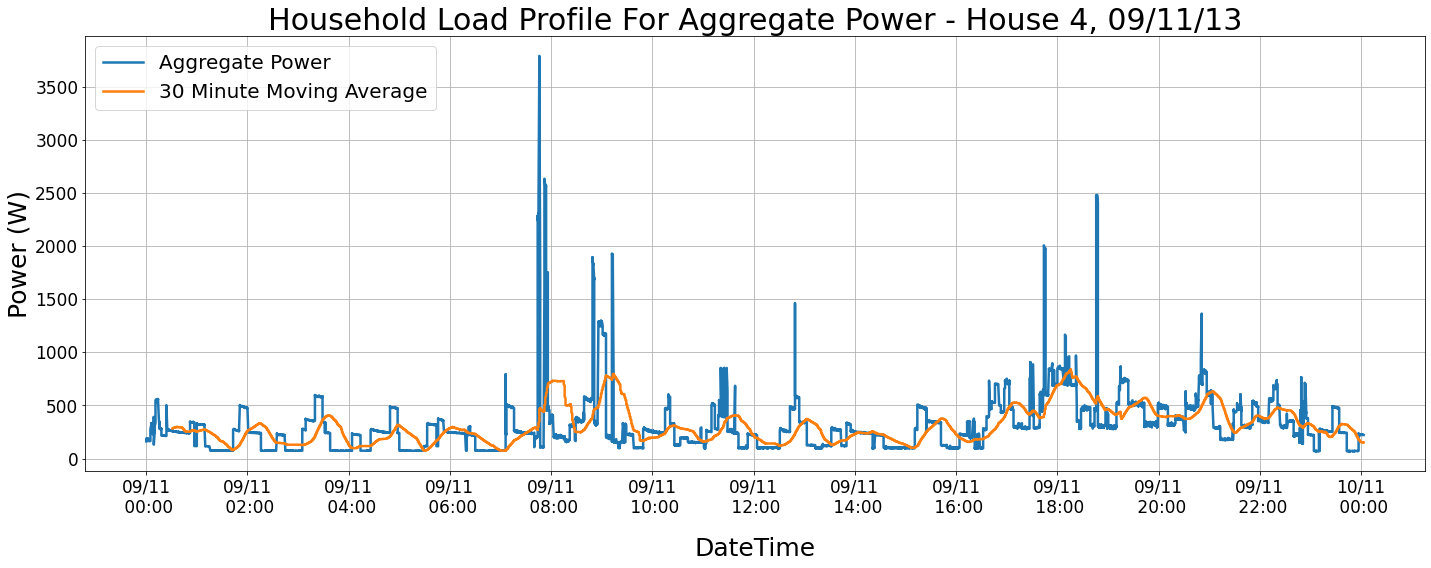

In [ ]:
fig=plt.figure(figsize=(24,8))
ax=fig.add_subplot(111, label="1")
# frequencyHouse = round(len(EVdata)/77)
# plt.xticks(np.arange(0,len(EVdata),frequencyHouse),fontsize=10)    

ax.plot(Date, power, linewidth=2.5, label='Aggregate Power', ls='-')#, ls='-',marker='s',markevery=35000
ax.plot(Date, moving_average, linewidth=2.5, label='30 Minute Moving Average', ls='-')#, ls='-',marker='s',markevery=35000
# ax.plot(t_filter,p_filter, linewidth=2, label='Fridge', ls='-')#, ls='-',marker='s',markevery=35000


ax.set_xlabel("DateTime",fontsize=25)
ax.set_ylabel("Power (W)",fontsize=25)
#ax.axhline(300,color='limegreen',linewidth=1.5,label='Classifier Threshold')
ax.tick_params(axis='x',labelsize=17) #, rotation=45
ax.tick_params(axis='y',labelsize=17)
ax.xaxis.labelpad = 20
ax.grid()
#ax.get_xaxis().set_visible(False)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=2, fontsize = 20)
ax.xaxis.set_major_locator(md.HourLocator(byhour=[0,2,4,6,8,10,12,14,16,18,20,22]))
ax.xaxis.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
#ax.xlim(left=0,right=0)
plt.title('Household Load Profile For Aggregate Power - House 4, 09/11/13',fontsize=30)
#plt.show()

Text(0.5, 1.0, 'Household Load Profile For Individual Applicances - House 4, 09/11/13')

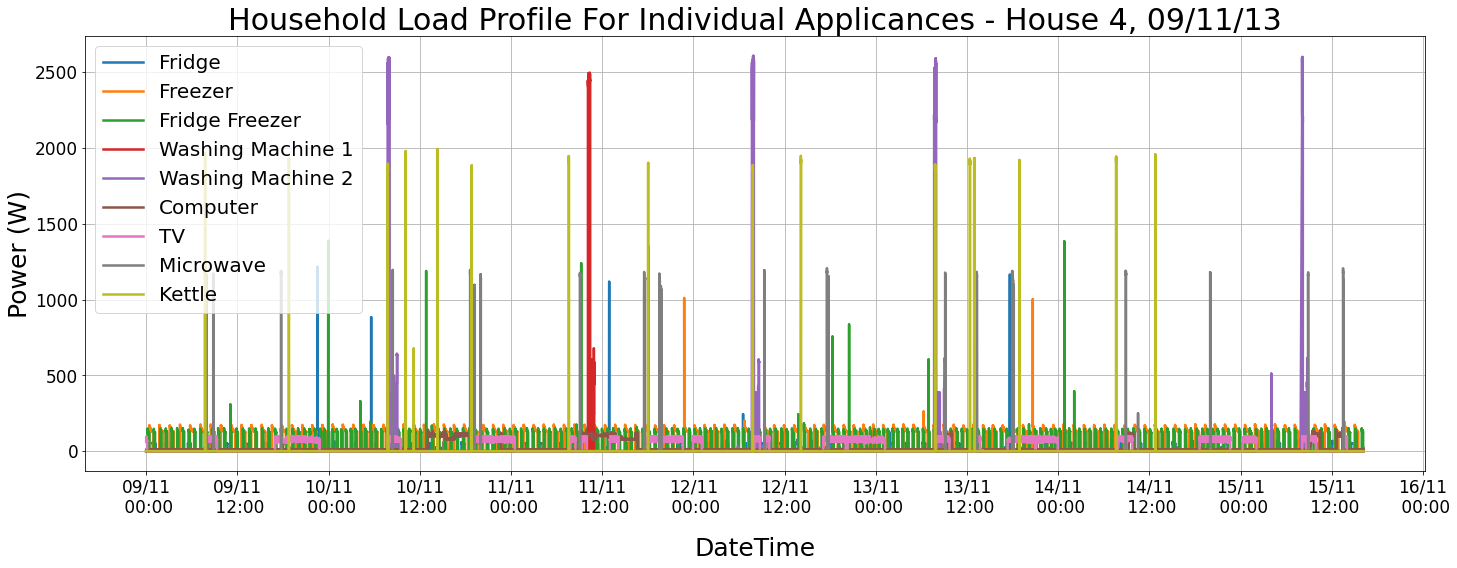

In [ ]:
fig=plt.figure(figsize=(24,8))
ax=fig.add_subplot(111, label="1")
# frequencyHouse = round(len(EVdata)/77)
# plt.xticks(np.arange(0,len(EVdata),frequencyHouse),fontsize=10)    

# ax.plot(Date, power, linewidth=2, label='Aggregate Power', ls='-')#, ls='-',marker='s',markevery=35000

ax.plot(Date, fridge, linewidth=2.5, label='Fridge', ls='-')#, ls='-',marker='s',markevery=35000
ax.plot(Date, freezer, linewidth=2.5, label='Freezer', ls='-')
ax.plot(Date, fridge_freezer, linewidth=2.5, label='Fridge Freezer', ls='-')
ax.plot(Date, washingmachine1, linewidth=2.5, label='Washing Machine 1', ls='-')
ax.plot(Date, washingmachine2, linewidth=2.5, label='Washing Machine 2', ls='-')
ax.plot(Date, computer, linewidth=2.5, label='Computer', ls='-')
ax.plot(Date, tv, linewidth=2.5, label='TV', ls='-')
ax.plot(Date, microwave, linewidth=2.5, label='Microwave', ls='-')
ax.plot(Date, kettle, linewidth=2.5, label='Kettle', ls='-')
ax.set_xlabel("DateTime",fontsize=25)
ax.set_ylabel("Power (W)",fontsize=25)
#ax.axhline(300,color='limegreen',linewidth=1.5,label='Classifier Threshold')
ax.tick_params(axis='x',labelsize=17) #, rotation=45
ax.tick_params(axis='y',labelsize=17)
ax.xaxis.labelpad = 20
ax.grid()
#ax.get_xaxis().set_visible(False)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=2, fontsize = 20)
ax.xaxis.set_major_locator(md.HourLocator(byhour=[0,12]))
ax.xaxis.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
#ax.xlim(left=0,right=0)
plt.title('Household Load Profile For Individual Applicances - House 4, 09/11/13',fontsize=30)
#plt.show()

In [ ]:
data['moving_avg'] = data.Aggregate.rolling(window=300).mean() 

Date = data['date']
power = data['Aggregate']
Unix = data['Unix']
moving_average_power=data[ 'moving_avg' ] 

In [ ]:
# Date=Date.apply(str)    #turn panda column into string
# Date=Date.str.replace(' ','\n')

In [ ]:
# Date=Date.drop(Date.index[74633:334038]) # 1 day
# power=power.drop(power.index[74633:334038])
# Unix=Unix.drop(Unix.index[74633:334038])
# moving_average_power=moving_average_power.drop(moving_average_power.index[74633:334038])
Date=Date.drop(Date.index[27372:334038]) # 1 day
power=power.drop(power.index[27372:334038])
Unix=Unix.drop(Unix.index[27372:334038])
moving_average_power=moving_average_power.drop(moving_average_power.index[27372:334038])

In [ ]:
t_filter = Date[Date.index % 10 == 0] #filter columns by using every 10th value or every 1th minute
p_filter = power[power.index % 10 == 0]
u_filter = Unix[Unix.index % 10 ==0]
mva_filter = moving_average_power[moving_average_power.index % 10 == 0]
# Housedate=Housedate.apply(str)    #turn panda column into string
# Housedate=Housedate.str.replace(' ','\n')

In [ ]:
df = pd.DataFrame(list(zip(t_filter,u_filter,p_filter,mva_filter)), columns =['date','unix','power','mva_power'])
df['mva_power'].fillna(method='bfill', inplace=True)

In [ ]:
df

,date,unix,power,mva_power
0,04/11/2013 00:00,1383523201,357,351.770000
1,04/11/2013 00:01,1383523261,356,351.770000
2,04/11/2013 00:02,1383523320,344,351.770000
3,04/11/2013 00:03,1383523380,335,351.770000
4,04/11/2013 00:04,1383523441,335,351.770000
...,...,...,...,...
2733,05/11/2013 23:35,1383694554,224,502.293333
2734,05/11/2013 23:36,1383694613,208,496.320000
2735,05/11/2013 23:37,1383694675,205,490.050000
2736,05/11/2013 23:38,1383694735,222,484.163333


In [ ]:
df['date']=pd.to_datetime(df['date'],dayfirst=True)

In [ ]:
df

,date,unix,power,mva_power
0,2013-11-04 00:00:00,1383523201,357,351.770000
1,2013-11-04 00:01:00,1383523261,356,351.770000
2,2013-11-04 00:02:00,1383523320,344,351.770000
3,2013-11-04 00:03:00,1383523380,335,351.770000
4,2013-11-04 00:04:00,1383523441,335,351.770000
...,...,...,...,...
2733,2013-11-05 23:35:00,1383694554,224,502.293333
2734,2013-11-05 23:36:00,1383694613,208,496.320000
2735,2013-11-05 23:37:00,1383694675,205,490.050000
2736,2013-11-05 23:38:00,1383694735,222,484.163333


In [ ]:
print(df['date'].dtype)

datetime64[ns]


In [ ]:
df.drop_duplicates(subset="date",inplace=True)

In [ ]:
df.set_index('date',inplace=True)

In [ ]:
df

,unix,power,mva_power
date,,,
2013-11-04 00:00:00,1383523201,357,351.770000
2013-11-04 00:01:00,1383523261,356,351.770000
2013-11-04 00:02:00,1383523320,344,351.770000
2013-11-04 00:03:00,1383523380,335,351.770000
2013-11-04 00:04:00,1383523441,335,351.770000
...,...,...,...
2013-11-05 23:35:00,1383694554,224,502.293333
2013-11-05 23:36:00,1383694613,208,496.320000
2013-11-05 23:37:00,1383694675,205,490.050000


In [ ]:
df = df.resample('T').ffill()

In [ ]:
print(df)
print(df.index.dtype)
df.index.freq='T'
print(df.index.freq)

                           unix  power   mva_power
date                                              
2013-11-04 00:00:00  1383523201    357  351.770000
2013-11-04 00:01:00  1383523261    356  351.770000
2013-11-04 00:02:00  1383523320    344  351.770000
2013-11-04 00:03:00  1383523380    335  351.770000
2013-11-04 00:04:00  1383523441    335  351.770000
...                         ...    ...         ...
2013-11-05 23:35:00  1383694554    224  502.293333
2013-11-05 23:36:00  1383694613    208  496.320000
2013-11-05 23:37:00  1383694675    205  490.050000
2013-11-05 23:38:00  1383694735    222  484.163333
2013-11-05 23:39:00  1383694793    208  477.316667

[2860 rows x 3 columns]
datetime64[ns]
<Minute>


In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(t_filter,p_filter,linewidth=1)
plt.plot(t_filter,mva_filter,linewidth=1)
plt.ylabel("Power (W)",fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.title('Household load profile - November 2013',fontsize=15)
frequency = 500
plt.xticks(np.arange(0,len(t_filter),frequency),fontsize=5)
plt.grid()
plt.show()

# Check for stationarity

In [ ]:
power = df['power']
power.head()

date
2013-11-04 00:00:00    357
2013-11-04 00:01:00    356
2013-11-04 00:02:00    344
2013-11-04 00:03:00    335
2013-11-04 00:04:00    335
Freq: T, Name: power, dtype: int64

In [ ]:
trainrand, testrand = train_test_split(power, test_size=.3, random_state=42, shuffle=True)
print('data length: ', df.shape[0])
print('train length: ', trainrand.shape[0])
print('test length: ', testrand.shape[0])

data length:  2860
train length:  2002
test length:  858


In [ ]:
print(trainrand)

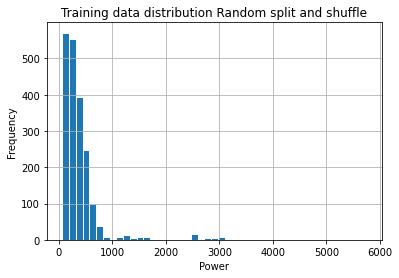

In [ ]:
ax = plt.hist(trainrand, bins=45, edgecolor='white', linewidth=1)
plt.title('Training data distribution Random split and shuffle')
plt.ylabel('Frequency')
plt.xlabel('Power');
plt.grid()
# plt.xticks(np.arange(-10, 35, 5))
# plt.yticks(np.arange(0, 200, 50))

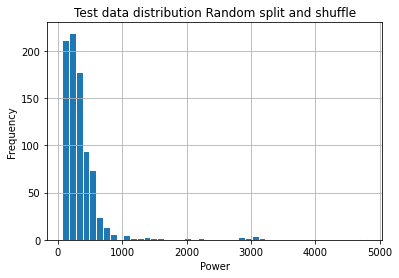

In [ ]:
plt.hist(testrand, bins=45, edgecolor='white', linewidth=1)
plt.title('Test data distribution Random split and shuffle')
plt.ylabel('Frequency')
plt.xlabel('Power');
plt.grid()
# plt.xticks(np.arange(-10, 35, 5))
# plt.yticks(np.arange(0, 100, 25))

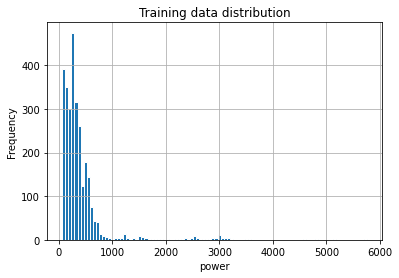

In [ ]:
ax=plt.hist(power, bins=100, edgecolor='white', linewidth=1)
plt.title('Training data distribution')
plt.ylabel('Frequency')
plt.xlabel('power');
plt.grid()

In [ ]:
def adfuller_test(power):
    result=adfuller(power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(df['power'])

ADF Test Statistic : -7.935289893191582
p-value : 3.426537180745378e-12
#Lags Used : 18
Number of Observations Used : 2841
ADF Statistic: -7.935290
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


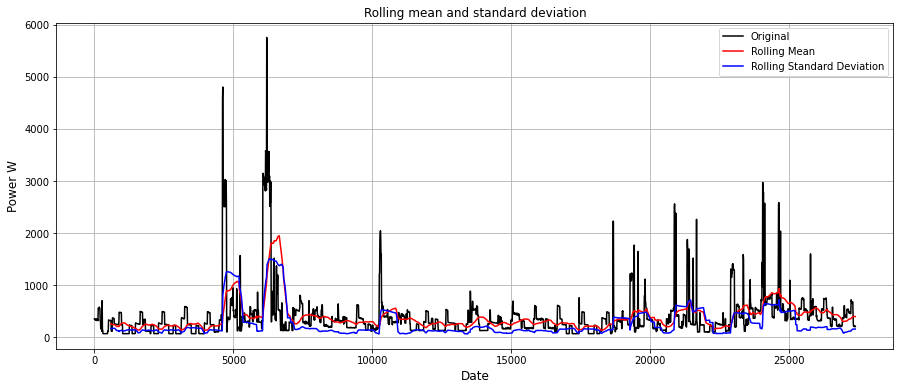

In [ ]:
# rmean1=power.rolling(window=60).mean()
# rstd1=power.rolling(window=60).std()
rmean1=p_filter.rolling(window=60).mean()
rstd1=p_filter.rolling(window=60).std()
#print(rmean1,rstd1)
plt.figure(figsize=(15,6))
orig=plt.plot(p_filter, color='black',label='Original')
mean= plt.plot(rmean1 , color='red',label='Rolling Mean')
std=plt.plot(rstd1,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.ylabel("Power W", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid()
plt.show(block=False)

In [ ]:
# stepWiseFit = auto_arima(df['power'],trace=True, supress_warnings=True, max_p=50,  max_order=100)
# stepWiseFit.summary()

In [ ]:
acf_values = acf(df['power'])
acf_values

array([1.        , 0.85906695, 0.74725531, 0.69408276, 0.66471694,
       0.63428611, 0.58612018, 0.54964472, 0.5062147 , 0.47172985,
       0.44128735, 0.41348766, 0.39112788, 0.3757198 , 0.34204578,
       0.29838892, 0.26310974, 0.23714003, 0.22856257, 0.22225056,
       0.20775824, 0.19415507, 0.18081794, 0.16860293, 0.16156308,
       0.15701093, 0.15233718, 0.14412213, 0.13407894, 0.12500301,
       0.1026083 , 0.08006993, 0.08143952, 0.08136771, 0.08061197])

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


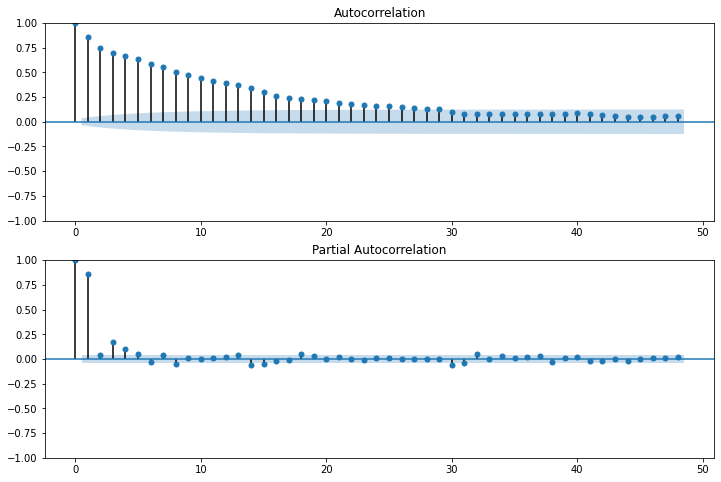

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = smapi.graphics.tsa.plot_acf(df['power'], lags=48, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = smapi.graphics.tsa.plot_pacf(df['power'], lags=48, ax=ax2)# , lags=40

# Train Test Split

In [ ]:
data_length = df.shape[0]
split70 = round(data_length*0.7)
train = df.iloc[:split70]
test = df.iloc[split70:]
print('data length: ', df.shape[0])
print('train length: ', train.shape[0])
print('test length: ', test.shape[0])

data length:  2860
train length:  2002
test length:  858


In [ ]:
train

,unix,power,mva_power
date,,,
2013-11-04 00:00:00,1383523201,357,351.770000
2013-11-04 00:01:00,1383523261,356,351.770000
2013-11-04 00:02:00,1383523320,344,351.770000
2013-11-04 00:03:00,1383523380,335,351.770000
2013-11-04 00:04:00,1383523441,335,351.770000
...,...,...,...
2013-11-05 09:17:00,1383643079,222,517.120000
2013-11-05 09:18:00,1383643139,229,483.836667
2013-11-05 09:19:00,1383643199,221,451.066667


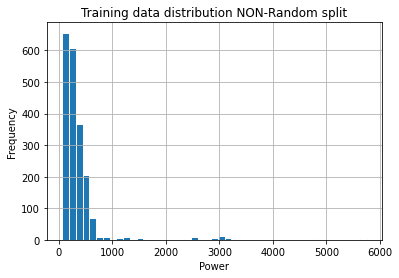

In [ ]:
ax = plt.hist(train['power'], bins=45, edgecolor='white', linewidth=1)
plt.title('Training data distribution NON-Random split')
plt.ylabel('Frequency')
plt.xlabel('Power');
plt.grid()

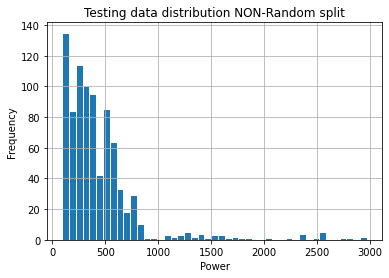

In [ ]:
ax = plt.hist(test['power'], bins=45, edgecolor='white', linewidth=1)
plt.title('Testing data distribution NON-Random split')
plt.ylabel('Frequency')
plt.xlabel('Power');
plt.grid()

In [ ]:
print(train)
print(train.index.dtype)

                           unix  power   mva_power
date                                              
2013-11-04 00:00:00  1383523201    357  351.770000
2013-11-04 00:01:00  1383523261    356  351.770000
2013-11-04 00:02:00  1383523320    344  351.770000
2013-11-04 00:03:00  1383523380    335  351.770000
2013-11-04 00:04:00  1383523441    335  351.770000
...                         ...    ...         ...
2013-11-05 09:17:00  1383643079    222  517.120000
2013-11-05 09:18:00  1383643139    229  483.836667
2013-11-05 09:19:00  1383643199    221  451.066667
2013-11-05 09:20:00  1383643258    200  417.503333
2013-11-05 09:21:00  1383643319    223  383.770000

[2002 rows x 3 columns]
datetime64[ns]


# ARIMA

In [ ]:
arimamodel = ARIMA(train['power'], order=(10,0,1))
arimamodel = arimamodel.fit()
arimamodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  power   No. Observations:                 2002
Model:                ARIMA(10, 0, 1)   Log Likelihood              -13571.489
Date:                Wed, 16 Mar 2022   AIC                          27168.977
Time:                        20:07:13   BIC                          27241.802
Sample:                    11-04-2013   HQIC                         27195.716
                         - 11-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        363.8431    110.166      3.303      0.001     147.921     579.765
ar.L1          0.4504      0.358      1.257      0.209      -0.252       1.153
ar.L2          0.1671      0.321      0.521      0.603      -0.462       0.796
ar.L3          0.1199      0.087      1.373      0.170      -0.051       0.291
ar.L4          0.1169      0.081      1.437      0.151      -0.043       0.276
ar.L5          0.0178      0.025      0.720      0.472      -0.031       0.066
ar.L6         -0.0080      0.023     -0.355      0.722      -0.052       0.036
ar.L7         -0.0117      0.025     -0.466      0.642      -0.061       0.037
ar.L8          0.0516      0.023      2.237      0.025       0.006       0.097
ar.L9         -0.0337      0.026     -1.306      0.192      -0.084       0.017
ar.L10         0.0203      0.022      0.928      0.353      -0.023       0.063
ma.L1          0.4495      0.356      1.262      0.207      -0.249       1.148
sigma2      4.549e+04    261.808    173.769      0.000     4.5e+04     4.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1784982.67
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             6.54
Prob(H) (two-sided):                  0.00   Kurtosis:                       148.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(train)
end = len(train) + len(test) -1
arimapred = arimamodel.predict(start=start, end=end, typ='levels')
arimapred

2013-11-05 09:22:00    254.469921
2013-11-05 09:23:00    245.501272
2013-11-05 09:24:00    253.092279
2013-11-05 09:25:00    259.414093
2013-11-05 09:26:00    266.533916
                          ...    
2013-11-05 23:35:00    363.843067
2013-11-05 23:36:00    363.843067
2013-11-05 23:37:00    363.843067
2013-11-05 23:38:00    363.843067
2013-11-05 23:39:00    363.843067
Freq: T, Name: predicted_mean, Length: 858, dtype: float64

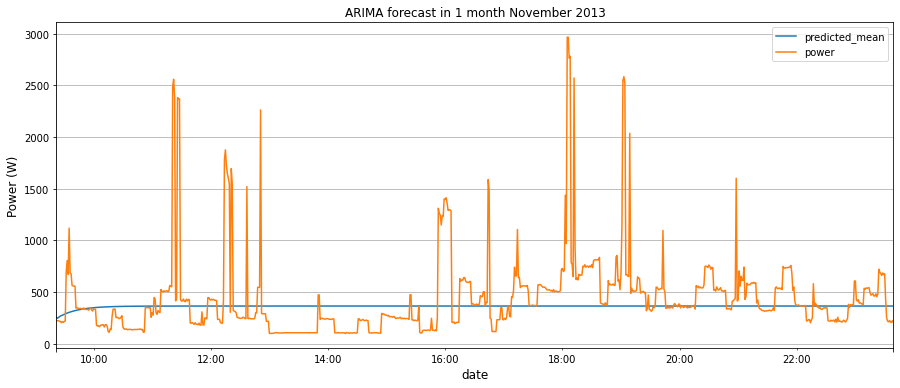

In [ ]:
arimapred.plot(legend = True, figsize=(15,6))
plt.title('ARIMA forecast in 1 month November 2013', fontsize=12)
plt.ylabel("Power (W)", fontsize=12)
plt.xlabel("Date", fontsize=12)
test['power'].plot(legend = True)
plt.grid()

In [ ]:
print("ARIMA RMSE: ", sqrt(mean_squared_error(arimapred,test['power'])))
print("ARIMA MSE: ", mean_squared_error(arimapred, test['power']))
print("ARIMA MAE: ", mean_absolute_error(arimapred, test['power']))
print("ARIMA Rolling R2 Score: ", r2_score(arimapred, test['power']))

ARIMA RMSE:  405.3203525332561
ARIMA MSE:  164284.58817768298
ARIMA MAE:  225.57502144429247
ARIMA Rolling R2 Score:  -1011.7751710712802


# Rolling ARIMA
https://machinelearningmastery.com/make-sample-forecasts-arima-python/

In [ ]:
df

,unix,power,mva_power
date,,,
2013-11-04 00:00:00,1383523201,357,351.770000
2013-11-04 00:01:00,1383523261,356,351.770000
2013-11-04 00:02:00,1383523320,344,351.770000
2013-11-04 00:03:00,1383523380,335,351.770000
2013-11-04 00:04:00,1383523441,335,351.770000
...,...,...,...
2013-11-05 23:35:00,1383694554,224,502.293333
2013-11-05 23:36:00,1383694613,208,496.320000
2013-11-05 23:37:00,1383694675,205,490.050000


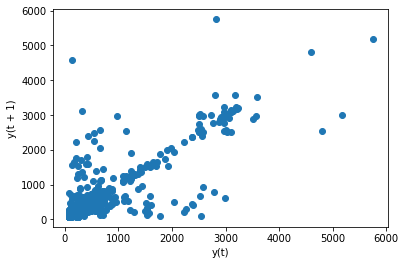

In [ ]:
plt.figure()
lag_plot(df['power'],lag=1)
plt.show()

In [ ]:
data_length = df.shape[0]
split70 = round(data_length*0.7)
train_data = df.iloc[:split70]
test_data = df.iloc[split70:]

print(train_data)
print(test_data)

training_data = train_data['power'].values  #take the price column values
test_data = test_data['power'].values
history = [x for x in training_data]  #list comprehension to iterate through training_data
model_predictions = []  #instantiate empty list
N_test_observations = len(test_data)  
for t in range(N_test_observations):
  model = smapi.tsa.arima.ARIMA(history, order=(1,0,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  model_predictions.append(yhat)
  true_test_value = test_data[t]
  history.append(true_test_value)
  # print('predicted=%f, expected=%f' % (yhat, true_test_value))



                           unix  power   mva_power
date                                              
2013-11-04 00:00:00  1383523201    357  351.770000
2013-11-04 00:01:00  1383523261    356  351.770000
2013-11-04 00:02:00  1383523320    344  351.770000
2013-11-04 00:03:00  1383523380    335  351.770000
2013-11-04 00:04:00  1383523441    335  351.770000
...                         ...    ...         ...
2013-11-05 09:17:00  1383643079    222  517.120000
2013-11-05 09:18:00  1383643139    229  483.836667
2013-11-05 09:19:00  1383643199    221  451.066667
2013-11-05 09:20:00  1383643258    200  417.503333
2013-11-05 09:21:00  1383643319    223  383.770000

[2002 rows x 3 columns]
                           unix  power   mva_power
date                                              
2013-11-05 09:22:00  1383643379    221  363.426667
2013-11-05 09:23:00  1383643379    221  363.426667
2013-11-05 09:24:00  1383643443    222  361.910000
2013-11-05 09:25:00  1383643502    217  360.986667
2013-1

858
2002


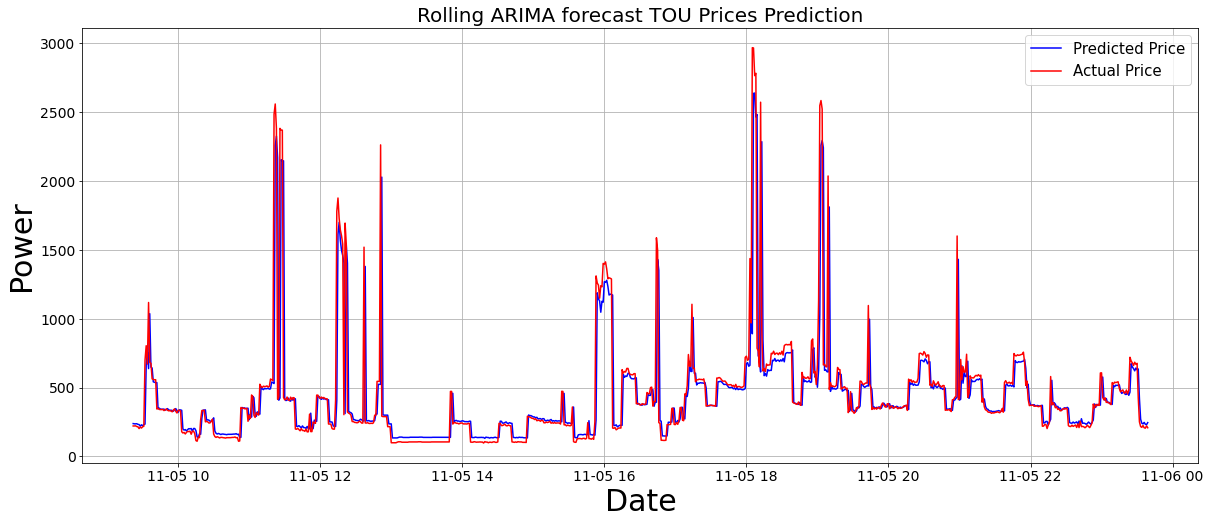

In [ ]:
test_set_range = df[int(len(df)*0.7):].index
# train_set_range = df[:int(len(df)*0.7)+1].index
# train_set_range = train_set_range[1:]
test_set_range=test_set_range[1:]
# print(test_set_range)
# training_data = training_data[1:]
# print(train_set_range)
print(len(test_data))
print(len(training_data))

plt.figure(figsize=(20,8))
# plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, model_predictions, color='blue',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
# plt.plot(train_set_range,training_data)
plt.title('Rolling ARIMA forecast TOU Prices Prediction',fontsize=20)
plt.xlabel('Date',fontsize=30)
plt.ylabel('Power',fontsize=30)
plt.tick_params(axis='y',labelsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [ ]:
test_set_range = df[int(len(df)*0.7):].index
train_set_range = df[:int(len(df)*0.7)].index
test_set_range

DatetimeIndex(['2013-11-05 09:21:00', '2013-11-05 09:22:00',
               '2013-11-05 09:23:00', '2013-11-05 09:24:00',
               '2013-11-05 09:25:00', '2013-11-05 09:26:00',
               '2013-11-05 09:27:00', '2013-11-05 09:28:00',
               '2013-11-05 09:29:00', '2013-11-05 09:30:00',
               ...
               '2013-11-05 23:30:00', '2013-11-05 23:31:00',
               '2013-11-05 23:32:00', '2013-11-05 23:33:00',
               '2013-11-05 23:34:00', '2013-11-05 23:35:00',
               '2013-11-05 23:36:00', '2013-11-05 23:37:00',
               '2013-11-05 23:38:00', '2013-11-05 23:39:00'],
              dtype='datetime64[ns]', name='date', length=859, freq='T')

In [ ]:
print("ARIMA Rolling RMSE: ", sqrt(mean_squared_error(model_predictions,test_data)))
print("ARIMA Rolling MSE: ", mean_squared_error(model_predictions, test_data))
print("ARIMA Rolling MAE: ", mean_absolute_error(model_predictions, test_data))
print("ARIMA Rolling R2 Score: ", r2_score(model_predictions, test_data))
print("R2 Score (Accuracy Metric): ", round(r2_score(model_predictions, test_data),3)*100,"%")
# print("Prophet Accuracy: ", score(forecast['yhat'], test['y']))
print("test Rolling R2 Score: ", r2_score(test_data, test_data))

ARIMA Rolling RMSE:  273.75882551494755
ARIMA Rolling MSE:  74943.89454732349
ARIMA Rolling MAE:  90.73906218396152
ARIMA Rolling R2 Score:  0.3836586034011644
R2 Score (Accuracy Metric):  38.4 %
test Rolling R2 Score:  1.0


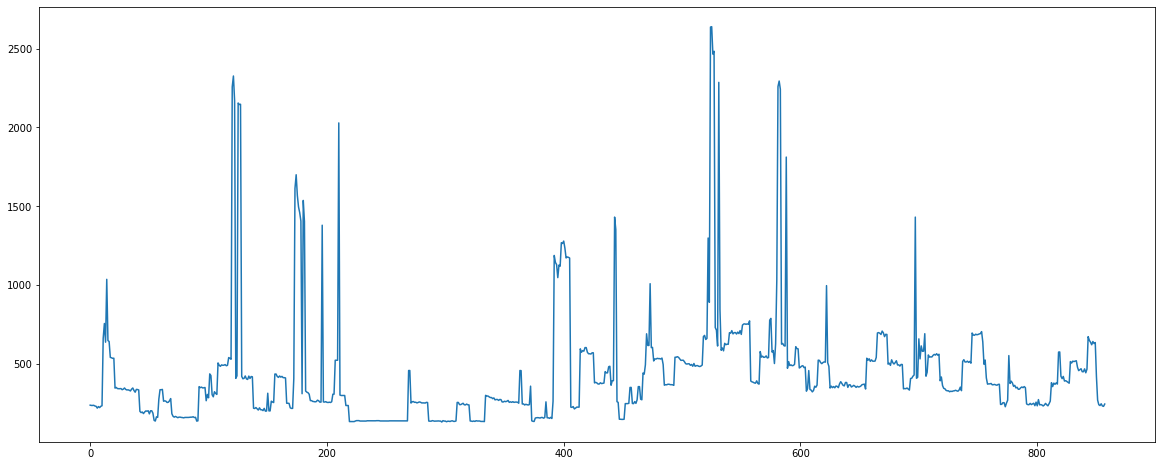

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(model_predictions)

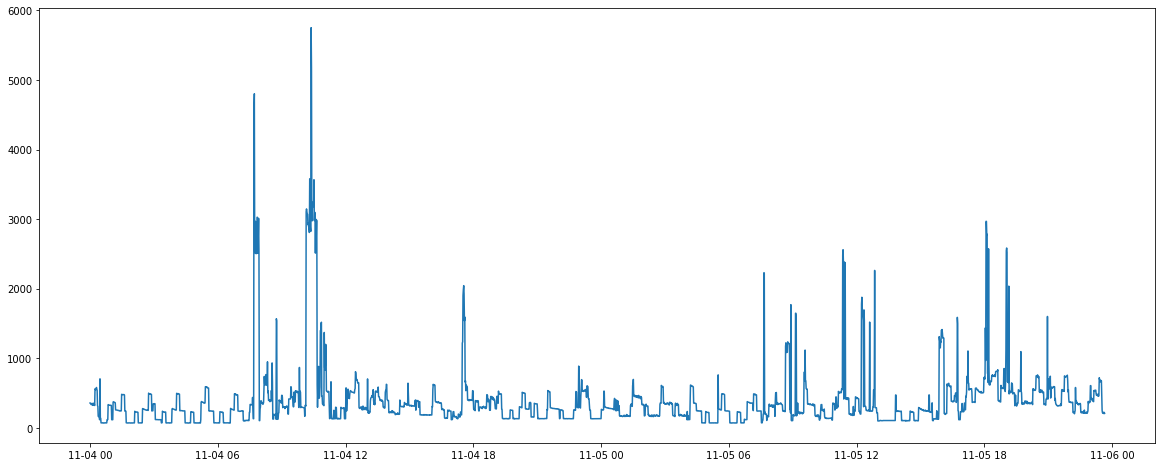

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df.power)

R2 Score:  0.9285714285714286
MAE Score:  0.8571428571428571


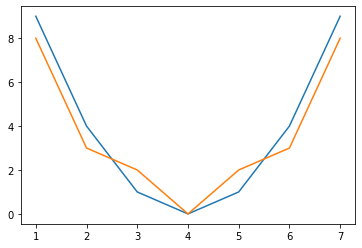

In [ ]:
x=[1,2,3,4,5,6,7]
y=[9,4,1,0,1,4,9]
# y2=[8,3,0,-1,0,3,8]
y2=[8,3,2,0,2,3,8]
y3=[10,5,2,1,2,5,10]
# straight_y=[2,2,2,2,2,2,2]
# straight_y2=[1,1,1,1,1,1,1]
# straight_y3=[3,3,3,3,3,3,3]
# straight_y4=[0,0,0,0,0,0,0]
# straight_y5=[4,4,4,4,4,4,4]
# straight_y6=[5,5,5,5,5,5,5]


plt.plot(x,y)
# plt.plot(x,straight_y)
# plt.plot(x,straight_y2)
# plt.plot(x,straight_y3)
# plt.plot(x,straight_y4)
# plt.plot(x,straight_y5)
# plt.plot(x,straight_y6)
plt.plot(x,y2)
# plt.plot(x,y3)

# print("0: R2 Score: ", r2_score(y, straight_y4))
# print("1: R2 Score: ", r2_score(y, straight_y2))
# print("2: R2 Score: ", r2_score(y, straight_y))
# print("3: R2 Score: ", r2_score(y, straight_y3))
# print("4: R2 Score: ", r2_score(y, straight_y5))
# print("4: R2 Score: ", r2_score(y, straight_y6))
print("R2 Score: ", r2_score(y, y2))
# print("R2 Score: ", r2_score(y, y3))

# print("0: MAE Score: ", mean_absolute_error(y, straight_y4))
# print("1: MAE Score: ", mean_absolute_error(y, straight_y2))
# print("2: MAE Score: ", mean_absolute_error(y, straight_y))
# print("3: MAE Score: ", mean_absolute_error(y, straight_y3))
# print("4: MAE Score: ", mean_absolute_error(y, straight_y5))
# print("4: MAE Score: ", mean_absolute_error(y, straight_y6))
print("MAE Score: ", mean_absolute_error(y, y2))
# print("MAE Score: ", mean_absolute_error(y, y3))
